### Categorizing the type of leaf disease from Apple tree

#### Problem Statement 

Predicting healthiness/disease of an apple tree based on leaf image

#### Performance Metric
https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/overview/evaluation

 mean column-wise ROC AUC

### 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install kaggle
!mkdir kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#need to be executed while downloading data-->> environment for downloading
import os
os.environ['KAGGLE_USERNAME'] = "interioamar" # username from the json file
os.environ['KAGGLE_KEY'] = "47689517b6c48c8c04cc85c362786587" # key from the json file

In [4]:
#https://stackoverflow.com/questions/51958553/error-while-importing-kaggle-dataset-on-colab
! echo chmod 600 ~/kaggle/kaggle.json

chmod 600 /root/kaggle/kaggle.json


In [5]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

100% 777M/779M [00:29<00:00, 22.6MB/s]
100% 779M/779M [00:29<00:00, 27.6MB/s]


In [ ]:
##unzipping the data
#https://askubuntu.com/questions/219392/how-can-i-uncompress-a-7z-file
!sudo apt install p7zip-full -y
!7z x plant-pathology-2020-fgvc7.zip

General information about the dataset:
1. Total number of images =3642
2. Target columns : Healthy, Multiple diseases, Rust, Scab

Dataset is having both train.csv & test.csv files

train.csv is having total 5 columns i.e. image_id and 4 categories of target columns labelled in binary format.

* Total number of datapoints in train.csv file are : 1821
* Total number of datapoints in test.csv file are : 1821
* Image_id: the unique key for datapoints

In [24]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print('Train & Test data shape: ', train_df.shape,test_df.shape) #test_df will have only image_id in it 
train_df.head(5)

Train & Test data shape:  (1821, 5) (1821, 1)


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### 2. EDA & Overview of Data

In [8]:
train_df.describe()[:3]

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539


#### Observations:
* Here count for all the category remains same since target classes are one hot encodeed
* We can see the mean of "multiple_diseases" is smaller followed by "healthy". It indicates there are less records which categorize multiple disease leaf and healthy leaf
* Mean sum of all the classes is 1 which tells that records are not having multiclass labelling as well as each of records are labelled with one class 

In [9]:
#checking null/not null column
# we observe that all the categories are labelled and are not null
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


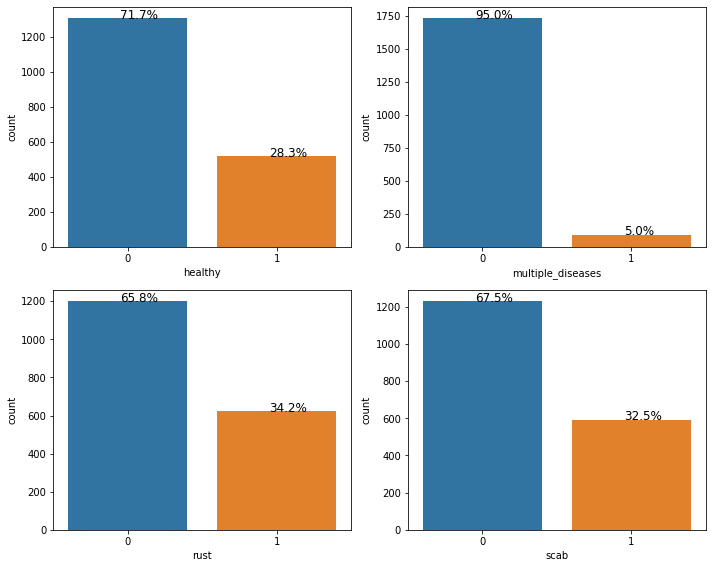

In [10]:
#https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn  -->> for annotating pecentage on top of bar
import seaborn as sns
import matplotlib.pyplot as plt

def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches: #Rectangle((x,y)=(-0.4, 0), width=0.8, height=1305, angle=0) -->> x=-0.4 
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)  #height is the count of class in dataset)
        x = p.get_x() + p.get_width() / 2 - 0.05  # -->> x is the start of box and width/2 makes points to center and subtract with 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

plt.figure(figsize=(10,8))
for index,i in enumerate(['healthy','multiple_diseases', 'rust', 'scab']):
  plt.subplot(2, 2, index+1)
  ax = sns.countplot(x=i,data=train_df)
  #percentage=dict(train_df[i].value_counts() *100/len(train_df[i]))
  without_hue(ax,train_df[i])
plt.tight_layout()
plt.show()

#### Observations:
* We observe that "rust"and "scab"category records are 34% and 32% respectively and "multiple_diseases" leaf category records are  only 5%
* Class imbalance exists where "multiple_disease" class becomes the minority class

#### Visualizing the sample leafs of all categories

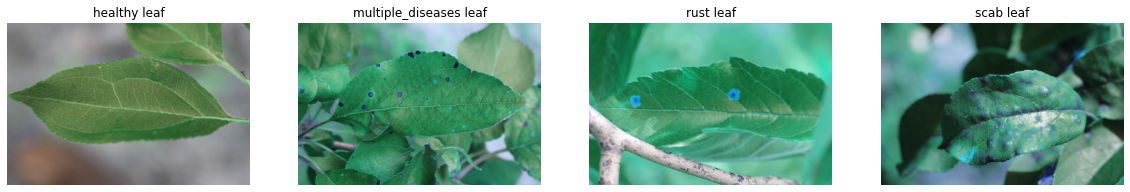

In [11]:
##https://www.kaggle.com/code/meemr5/plant-pathology-2020-eda-ia-ip-models/notebook

#visualizing the sample leaf
import numpy as np
#from google.colab.patches import cv2_imshow
import cv2
j=20  #input random number less than 91 since multiple disease records are 91
plt.figure(figsize=(20,10))
for index,i in enumerate(['healthy','multiple_diseases', 'rust', 'scab']):
  plt.subplot(1, 4, index+1) #(rows,col,index)
  image_id_1=train_df[train_df[i]==1]['image_id'].iloc[j]
  image=cv2.imread('images/{}.jpg'.format(image_id_1))
  plt.imshow(image)
  plt.axis('off')
  plt.title("{} leaf".format(i))

### 2.1  train and test image_size Analysis

In [12]:
#https://www.geeksforgeeks.org/finding-the-size-resolution-of-image-in-python/ 
from tqdm.notebook import tqdm
import shutil 
#train_image=[]
train_image_height=[]
train_image_width=[]

#test_image=[]
test_image_height=[]
test_image_width=[]
for i in tqdm(os.listdir('images/')):
    if "Train" in i:
      #train_image.append(i)
      image=cv2.imread('images/{}'.format(i))
      train_image_height.append(image.shape[0])
      train_image_width.append(image.shape[1])
      #moving the train images to train folder
      # shutil.copy('images/{}'.format(i), 'images/train/{}'.format(i)) #copying into specific folder
    
    elif "Test" in i:
      #test_image.append(i)
      image=cv2.imread('images/{}'.format(i))
      test_image_height.append(image.shape[0])
      test_image_width.append(image.shape[1])
      #moving the test images to test folder
      # shutil.copy('images/{}'.format(i), 'images/test/{}'.format(i)) #copying into specific folder



  0%|          | 0/3642 [00:00<?, ?it/s]

In [13]:
print("== Training image size check ===")
average_image_height=sum(train_image_height)/len(train_image_height)
average_image_width=sum(train_image_width)/len(train_image_width)
print("Average train image height and width are: ",average_image_height,average_image_width)
print("Minimum height and width are: ", min(train_image_height),min(train_image_width))
print("Maximum height and width are: ", max(train_image_height),max(train_image_width))

print("\n == Testing image size check ===")
average_test_image_height=sum(test_image_height)/len(test_image_height)
average_test_image_width=sum(test_image_width)/len(test_image_width)
print("Average test image height and width are: ",average_test_image_height,average_test_image_width)
print("Minimum height and width are: ", min(test_image_height),min(test_image_width))
print("Maximum height and width are: ", max(test_image_height),max(test_image_width))


== Training image size check ===
Average train image height and width are:  1365.7501372872048 2047.2498627127952
Minimum height and width are:  1365 1365
Maximum height and width are:  2048 2048

 == Testing image size check ===
Average test image height and width are:  1372.5013728720483 2040.4986271279517
Minimum height and width are:  1365 1365
Maximum height and width are:  2048 2048


#### Observations:
* Train and Test image sizes are almost same. So we can choose one standard size for an image.

#### Image Augmentation

* ImageDataGenerator generates batches of tensor image data with real-time data augmentations which expands the dataset size and makes the training data rich
* Transforms include image manipulation, such as shifts, rotation, brightness etc
* Below, sample leaf each classes are augmented with flip, rotation and brightness

In [19]:
#https://www.kaggle.com/code/meemr5/plant-pathology-2020-eda-ia-ip-models/notebook  -->> using tf.image
#https://www.tensorflow.org/tutorials/images/data_augmentation  -->>tf.keras.layers augmentation method
import tensorflow as tf
import random
def imageAugmentation(image,aug,leaf_type):

    plt.figure(figsize=(15,10))
    plt.subplot(1, 4, 1)
    plt.title("{} leaf Original Image".format(leaf_type[:10]))
    plt.imshow(image)
    plt.axis('off')
 
    if aug == True :
        
        plt.subplot(1, 4, 2)
        image1 = tf.image.random_brightness(image,max_delta=0.5,seed=10)  #brightness value ma_delta
        plt.title("Brightness Image")
        plt.imshow(image1)
        plt.axis('off')

        plt.subplot(1, 4, 3)
        image1 = tf.image.random_flip_left_right(image,seed=10)
        plt.title("Flipped left_right Image")
        plt.imshow(image1)
        plt.axis('off')

        plt.subplot(1, 4, 4)
        image1=tf.keras.layers.Rescaling(scale =1/255, offset=0.0)(image)
        image1 = tf.keras.layers.RandomRotation(0.8,interpolation='bilinear',fill_mode='nearest')(image1)
        plt.title("Rotated Image")
        plt.imshow(image1)
        plt.axis('off')

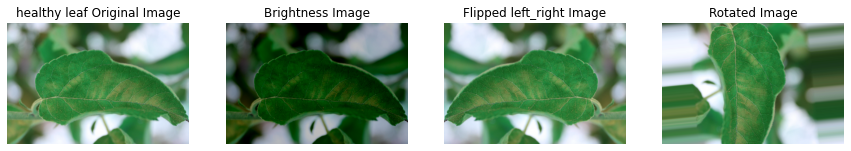

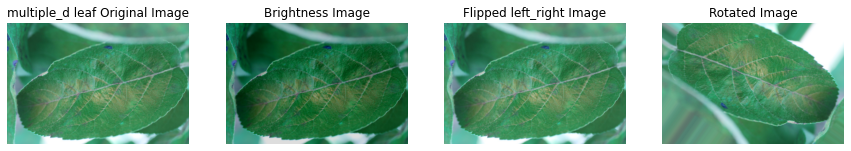

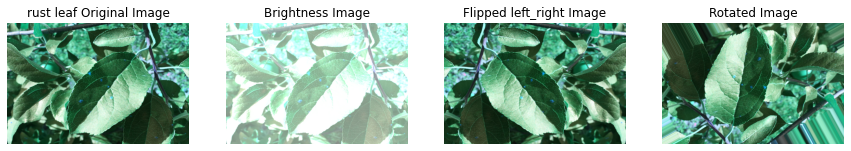

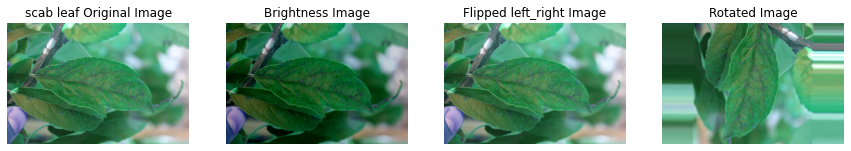

In [25]:
import cv2
for index,i in enumerate(['healthy','multiple_diseases', 'rust', 'scab']):
  image_id_1=train_df[train_df[i]==1]['image_id'].iloc[index]
  image=cv2.imread('images/{}.jpg'.format(image_id_1)) #'images/{}.jpg'.format(image_id_1)
  img = np.expand_dims(image,axis=0)
  leaf_type=i
  imageAugmentation(image,True,leaf_type)

### 3. Data Splitting & Augmentation

In [14]:
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
import h5py
from tensorflow.keras.models import load_model #for saving model weights
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
def append_ext(fn):
    return fn+".jpg"

train_df["image_id"]=train_df["image_id"].apply(append_ext)
test_df["image_id"]=test_df["image_id"].apply(append_ext)

In [16]:
train_df.head(3)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0.jpg,0,0,0,1
1,Train_1.jpg,0,1,0,0
2,Train_2.jpg,1,0,0,0


In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255.

                                 ,width_shift_range=0.2 
                                ,zoom_range=0.2
                                ,horizontal_flip=True 
                                ,validation_split=0.20)
val_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

In [ ]:
#https://stackoverflow.com/questions/55652574/how-to-solve-keyerror-unone-of-index-dtype-object-are-in-the-colum 
#https://stackoverflow.com/questions/56815476/very-good-validation-accuracy-but-bad-predictions/58590097#58590097  -->>shuffle=False setting on validation generator

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory="./images/",
x_col="image_id",
y_col=train_df.columns[1:].str.replace(' ', ''),
subset="training",
batch_size=16,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(320,512))

valid_generator=val_datagen.flow_from_dataframe(
dataframe=train_df,
directory="./images/",
x_col="image_id",
y_col=train_df.columns[1:].str.replace(' ', ''),
subset="validation",
batch_size=16,
seed=42,
shuffle=False, #is required to freeze the validation data while testing else different result is obtained 
class_mode="raw", #https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
target_size=(512,512))

Found 1457 validated image filenames.
Found 364 validated image filenames.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="./images/",
x_col="image_id",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(512,512))

Found 1821 validated image filenames.


### 4. Modelling

#### 4.1.1 Pre-Trained Keras Model: DenseNet121 + Augmentation
* Models are trained on Kaggle Kernels

##### CategoricalAccuracy class
* Calculates how often predictions match one-hot labels.
* y_pred and y_true should be passed in as vectors of probabilities, rather than as labels.(Passing all classses probabilities)
* It can used for finding accuracy for multiclass labels

In [ ]:
#https://github.com/pitmonticone/PlantDiseaseClassification/blob/master/Notebooks/notebook.ipynb
from keras.applications.densenet import DenseNet201, DenseNet121
import tensorflow as tf

METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc',multi_label=True),
        ]
    
model = tf.keras.Sequential([DenseNet121(input_shape=(512, 512, 3),
                                weights='imagenet',
                                include_top=False),
                                tf.keras.layers.GlobalAveragePooling2D(),
                                tf.keras.layers.Dense(4,activation='softmax')])
        
model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=METRICS)
    
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 6,957,956
Non-trainable params: 83,648
_________________________________________________________________
None


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten,MaxPool2D,Input
from pathlib import Path
import numpy as np

epoch=40


auc = tf.keras.metrics.AUC()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)


filepath="best_model_dense.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='min') 

callback_list=[earlystop,checkpoint] #,Lerning_scheduler

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

91 22


In [ ]:
History=model.fit(train_generator,
            steps_per_epoch = STEP_SIZE_TRAIN, #train_size//batch_size
            epochs=epoch,               # the model never seems to suffer from validation loss increase (even up to 100 epochs)
            verbose=1,
            validation_data=valid_generator,
            validation_steps=STEP_SIZE_VALID,      
           callbacks=callback_list)

Epoch 1/40
91/91 [==============================] - 117s 1s/step - loss: 0.3210 - accuracy: 0.8980 - auc: 0.9443 - val_loss: 4.0411 - val_accuracy: 0.5795 - val_auc: 0.7586

Epoch 00001: val_loss improved from inf to 4.04109, saving model to best_model_dense.hdf5
Epoch 2/40
91/91 [==============================] - 116s 1s/step - loss: 0.2260 - accuracy: 0.9271 - auc: 0.9655 - val_loss: 0.6842 - val_accuracy: 0.8295 - val_auc: 0.8981

Epoch 00002: val_loss improved from 4.04109 to 0.68420, saving model to best_model_dense.hdf5
Epoch 3/40
91/91 [==============================] - 116s 1s/step - loss: 0.3492 - accuracy: 0.8973 - auc: 0.9426 - val_loss: 2.3101 - val_accuracy: 0.3125 - val_auc: 0.6390

Epoch 00003: val_loss did not improve from 0.68420
Epoch 4/40
91/91 [==============================] - 115s 1s/step - loss: 0.2332 - accuracy: 0.9306 - auc: 0.9624 - val_loss: 0.4088 - val_accuracy: 0.8551 - val_auc: 0.9518

Epoch 00004: val_loss improved from 0.68420 to 0.40879, saving model 

#### Observation:
* We achieved 0.9710 ROC_AUC score on validation data
* val_accuracy: 0.9318
* Validation data had 364 images.
* DenseNet121 with Dataaumentation is trained with 1457 images.

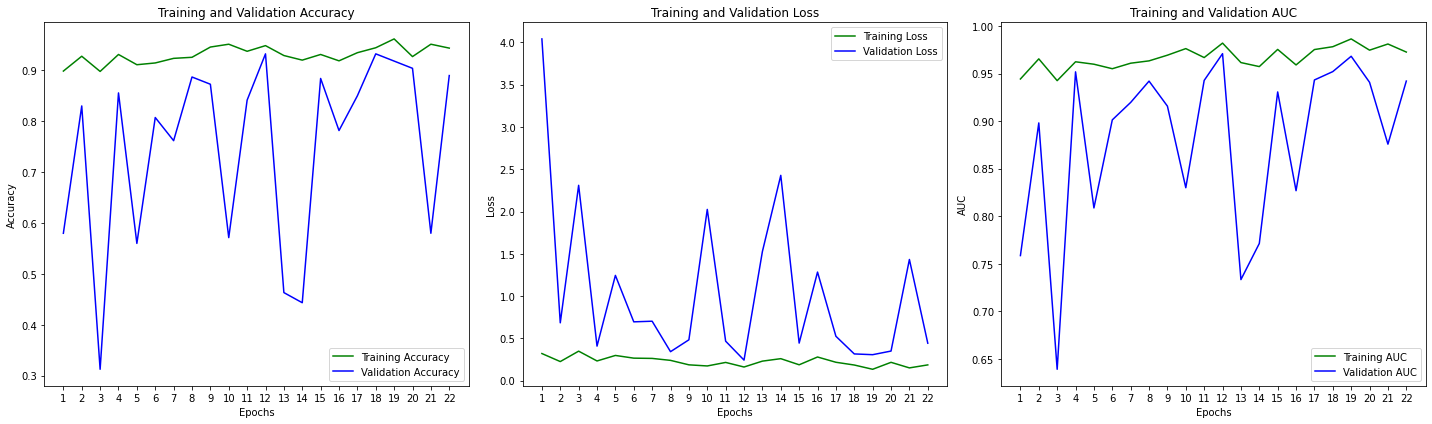

In [ ]:
train_acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epoachs = range(1,23)
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(epoachs,train_acc,'g',label='Training Accuracy')
plt.plot(epoachs,val_acc,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epoachs)
plt.ylabel("Accuracy")
plt.legend()

train_acc = History.history['loss']
val_acc = History.history['val_loss']
epoachs = range(1,23)
plt.subplot(1,3,2)
plt.plot(epoachs,train_acc,'g',label='Training Loss')
plt.plot(epoachs,val_acc,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epoachs)
plt.legend()

train_acc = History.history['auc']
val_acc = History.history['val_auc']
epoachs = range(1,23)
plt.subplot(1,3,3)
plt.plot(epoachs,train_acc,'g',label='Training AUC')
plt.plot(epoachs,val_acc,'b',label='Validation AUC')
plt.title("Training and Validation AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.xticks(epoachs)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import load_model
loaded_model = tf.keras.models.load_model('best_model_dense.hdf5')

364/364 [==============================] - 14s 38ms/step


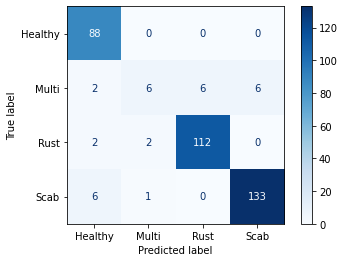

In [ ]:

#vaidation data prediction agin for confusion matrix 

valid_generator.reset()
pred_1=loaded_model.predict_generator(valid_generator,steps=valid_generator.n,verbose=1)

    #plotting function of accuracy,loss and auc
    
    #confusion_matrix on each fold
class_labels = ["Healthy", "Multi", "Rust", "Scab"]
cm = confusion_matrix(np.asarray(valid_generator._targets).argmax(axis=1), np.asarray(pred_1).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#running the prediction data

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred_dense_1= loaded_model.predict_generator(test_generator, STEP_SIZE_TEST,verbose=1)

1821/1821 [==============================] - 89s 48ms/step


In [ ]:
submission=pd.DataFrame(pred_dense_1,columns=["healthy", "multiple_diseases", "rust","scab"])
submission.reset_index(drop=True, inplace=True)

In [ ]:
test_df1=test_df['image_id'].map(lambda x: x.split('.')[0])

In [ ]:
submission.insert(0,'image_id',test_df1)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

submission.to_csv('dense_net.csv',index=False)

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='dense_net.csv')

* Public Score: 0.92735 ROC_AUC and Private Score: 0.92394 is achieved in Kaggle Submission

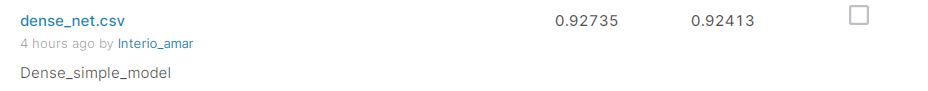

In [38]:
from IPython.display import Image 
Image(filename='DenseNet121_score.JPG',width = 1000, height = 100)

#### 4.1.2.  Pretrained DenseNet121 with K fold cross validation + Data Augmentation 


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout,GlobalMaxPooling2D
import h5py
from tensorflow.keras.models import load_model #for saving model weights
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

from keras.applications.densenet import DenseNet201, DenseNet121
from tqdm.notebook import tqdm
import gc
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Storing the average of all predictions
#https://github.com/r-sajal/DeepLearning-/blob/master/ComputerVision/k-fold-accuracy-comparison-blog.ipynb
data_kfold = pd.DataFrame()

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
def append_ext(fn):
    return fn+".jpg"

train_df["image_id"]=train_df["image_id"].apply(append_ext)
test_df["image_id"]=test_df["image_id"].apply(append_ext)

In [ ]:
# Creating X, Y for training 
train_y = train_df.iloc[:,1:]
train_y=tf.argmax(train_y,1)

train_x = train_df['image_id']

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 1
N_SPLIT =5

In [ ]:
def accuracy_loss_auc_plot(History,epoch):
  train_acc = History.history['accuracy']
  val_acc = History.history['val_accuracy']
  epoachs = range(1,epoch+1)
  plt.figure(figsize=(12,6))
  plt.subplot(1,3,1)
  plt.plot(epoachs,train_acc,'g',label='Training Accuracy')
  plt.plot(epoachs,val_acc,'b',label='Validation Accuracy')
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.xticks(epoachs)
  plt.ylabel("Accuracy")
  plt.legend()

  train_acc = History.history['loss']
  val_acc = History.history['val_loss']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,2)
  plt.plot(epoachs,train_acc,'g',label='Training Loss')
  plt.plot(epoachs,val_acc,'b',label='Validation Loss')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xticks(epoachs)
  plt.legend()

  train_acc = History.history['auc']
  val_acc = History.history['val_auc']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,3)
  plt.plot(epoachs,train_acc,'g',label='Training AUC')
  plt.plot(epoachs,val_acc,'b',label='Validation AUC')
  plt.title("Training and Validation AUC")
  plt.xlabel("Epochs")
  plt.ylabel("AUC")
  plt.xticks(epoachs)
  plt.legend()

  plt.tight_layout()
  plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Found 1456 validated image filenames.
Found 365 validated image filenames.
Epoch 1/15
91/91 [==============================] - 127s 1s/step - loss: 0.5611 - accuracy: 0.8242 - auc: 0.8872 - val_loss: 4.6079 - val_accuracy: 0.5909 - val_auc: 0.7028

Epoch 00001: val_loss improved from inf to 4.60790, saving model to best_model1.hdf5
Epoch 2/15
91/91 [==============================] - 117s 1s/step - loss: 0.3477 - accuracy: 0.8915 - auc: 0.9391 - val_loss: 0.9875 - val_accuracy: 0.7898 - val_auc: 0.8466

Epoch 00002: val_loss improved from 4.60790 to 0.98755, saving model to best_model1.hdf5
Epoch 3/15
91/91 [==============================] - 114s 1s/step - loss: 0.3306 - accuracy: 0.8956 - auc: 0.9418 - val_loss: 1.1087 - val_accuracy: 0.7273 - val_auc: 0.8844

Epoch 00003: val_loss did not improve from 0.98755
Epoch 4/15
91/91 [==============================] - 113s 1s/step - loss: 0.3222 - accuracy: 0.9018 - auc: 0.9301 - val_loss: 0.4620 - val_accuracy: 0.8381 - val_auc: 0.9275

Epoc

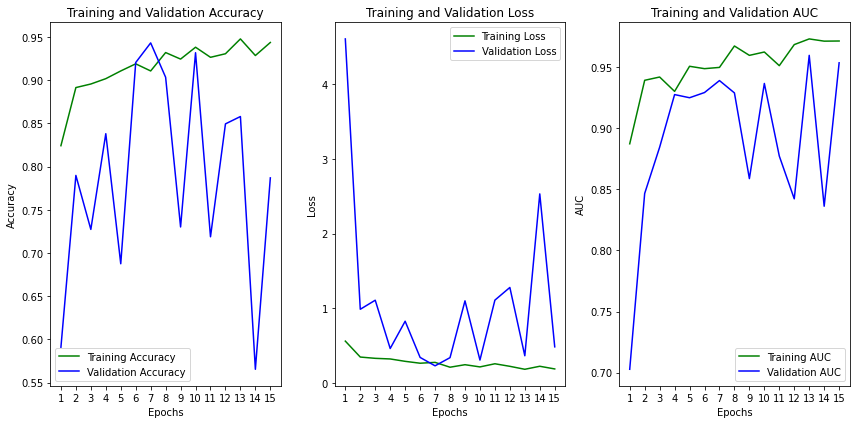

365/365 [==============================] - 14s 32ms/step


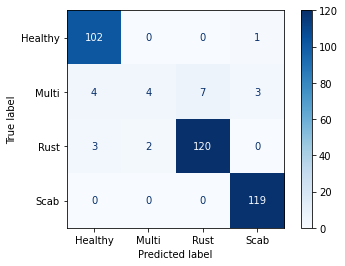

Found 1821 validated image filenames.
Concatenated data size is : (1821, 4)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 125s 1s/step - loss: 0.5456 - accuracy: 0.8210 - auc: 0.8845 - val_loss: 7.3141 - val_accuracy: 0.4886 - val_auc: 0.7356

Epoch 00001: val_loss improved from inf to 7.31407, saving model to best_model2.hdf5
Epoch 2/15
91/91 [==============================] - 113s 1s/step - loss: 0.4039 - accuracy: 0.8661 - auc: 0.9274 - val_loss: 6.9629 - val_accuracy: 0.3722 - val_auc: 0.6428

Epoch 00002: val_loss improved from 7.31407 to 6.96291, saving model to best_model2.hdf5
Epoch 3/15
91/91 [==============================] - 114s 1s/step - loss: 0.3595 - accuracy: 0.8931 - auc: 0.9161 - val_loss: 0.6411 - val_accuracy: 0.8153 - val_auc: 0.9090

Epoch 00003: val_loss improved from 6.96291 to 0.64109, saving model to best_model2.hdf5
Epoch 4/15
91/91 [==============================] - 114s 1s/step

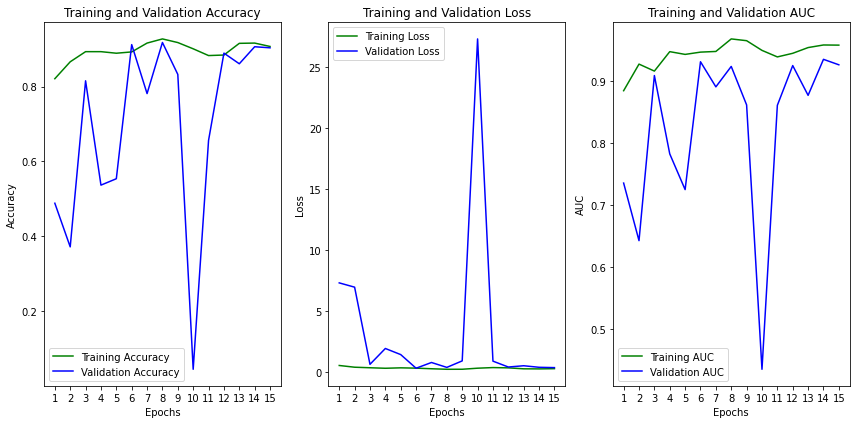

364/364 [==============================] - 15s 36ms/step


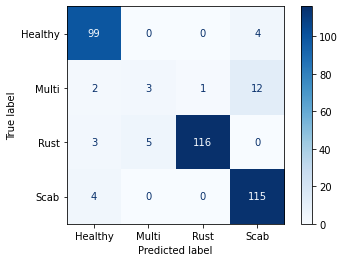

Found 1821 validated image filenames.
Concatenated data size is : (1821, 8)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 127s 1s/step - loss: 0.6052 - accuracy: 0.8008 - auc: 0.8724 - val_loss: 536.9971 - val_accuracy: 0.3409 - val_auc: 0.5000

Epoch 00001: val_loss improved from inf to 536.99707, saving model to best_model3.hdf5
Epoch 2/15
91/91 [==============================] - 113s 1s/step - loss: 0.3762 - accuracy: 0.8848 - auc: 0.9213 - val_loss: 4.2042 - val_accuracy: 0.4119 - val_auc: 0.6407

Epoch 00002: val_loss improved from 536.99707 to 4.20415, saving model to best_model3.hdf5
Epoch 3/15
91/91 [==============================] - 114s 1s/step - loss: 0.3775 - accuracy: 0.8862 - auc: 0.9287 - val_loss: 4.3694 - val_accuracy: 0.5483 - val_auc: 0.6788

Epoch 00003: val_loss did not improve from 4.20415
Epoch 4/15
91/91 [==============================] - 113s 1s/step - loss: 0.3358 - accuracy: 0.90

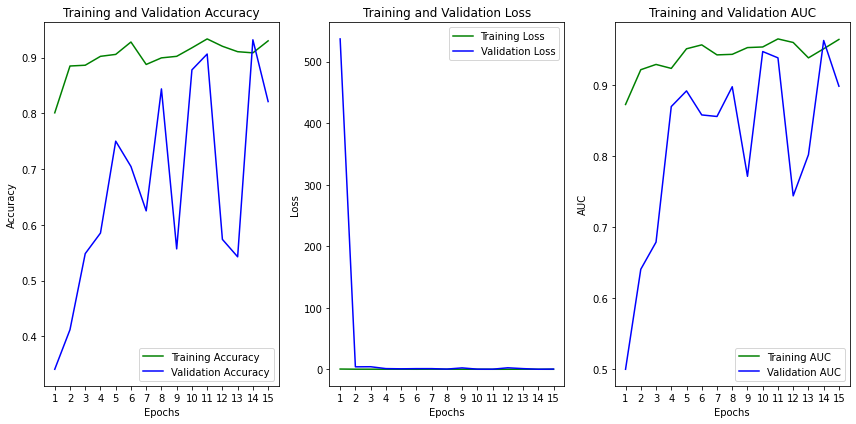

364/364 [==============================] - 14s 34ms/step


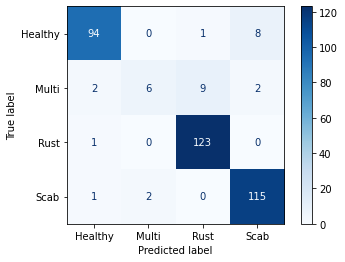

Found 1821 validated image filenames.
Concatenated data size is : (1821, 12)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 126s 1s/step - loss: 0.6533 - accuracy: 0.7897 - auc: 0.8526 - val_loss: 1.7862 - val_accuracy: 0.6932 - val_auc: 0.8003

Epoch 00001: val_loss improved from inf to 1.78616, saving model to best_model4.hdf5
Epoch 2/15
91/91 [==============================] - 113s 1s/step - loss: 0.4613 - accuracy: 0.8473 - auc: 0.9073 - val_loss: 0.8015 - val_accuracy: 0.7614 - val_auc: 0.9399

Epoch 00002: val_loss improved from 1.78616 to 0.80152, saving model to best_model4.hdf5
Epoch 3/15
91/91 [==============================] - 113s 1s/step - loss: 0.4322 - accuracy: 0.8737 - auc: 0.9006 - val_loss: 0.8563 - val_accuracy: 0.7017 - val_auc: 0.8551

Epoch 00003: val_loss did not improve from 0.80152
Epoch 4/15
91/91 [==============================] - 113s 1s/step - loss: 0.3705 - accuracy: 0.8786 - 

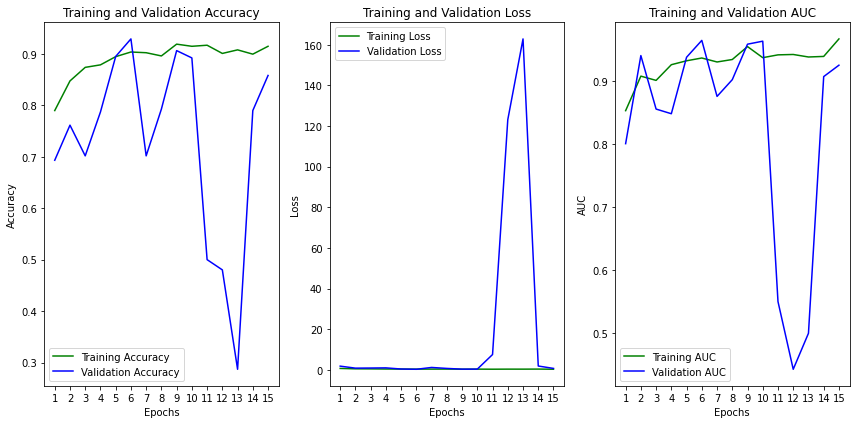

364/364 [==============================] - 14s 34ms/step


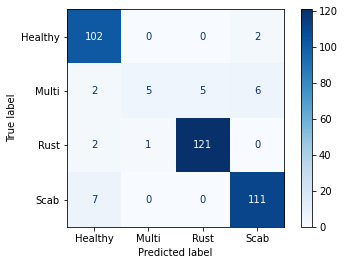

Found 1821 validated image filenames.
Concatenated data size is : (1821, 16)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 125s 1s/step - loss: 0.6586 - accuracy: 0.8043 - auc: 0.8623 - val_loss: 41.3609 - val_accuracy: 0.3409 - val_auc: 0.5000

Epoch 00001: val_loss improved from inf to 41.36088, saving model to best_model5.hdf5
Epoch 2/15
91/91 [==============================] - 113s 1s/step - loss: 0.3746 - accuracy: 0.8876 - auc: 0.9255 - val_loss: 7.9745 - val_accuracy: 0.5909 - val_auc: 0.7293

Epoch 00002: val_loss improved from 41.36088 to 7.97451, saving model to best_model5.hdf5
Epoch 3/15
91/91 [==============================] - 113s 1s/step - loss: 0.3329 - accuracy: 0.9042 - auc: 0.9321 - val_loss: 1.1373 - val_accuracy: 0.7386 - val_auc: 0.8480

Epoch 00003: val_loss improved from 7.97451 to 1.13726, saving model to best_model5.hdf5
Epoch 4/15
91/91 [==============================] - 113s 1s/

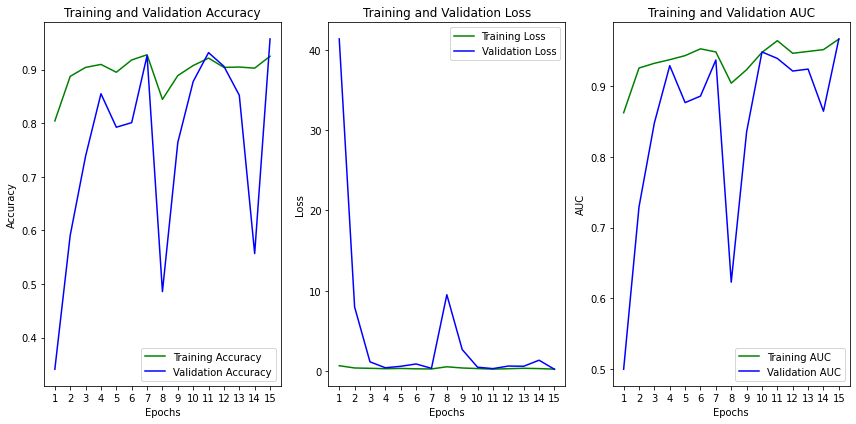

364/364 [==============================] - 14s 34ms/step


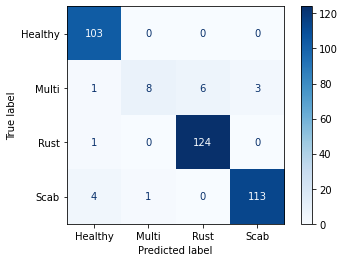

Found 1821 validated image filenames.
Concatenated data size is : (1821, 20)


In [ ]:
#https://github.com/r-sajal/DeepLearning-/blob/master/ComputerVision/k-fold-accuracy-comparison-blog.ipynb -->>K Fold cv

from keras.applications.densenet import DenseNet201, DenseNet121
from tqdm.notebook import tqdm
import pandas as pd
import tensorflow as tf
import gc
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

# Storing the average of all predictions
data_kfold = pd.DataFrame()

#Initializing Data Generators
train_datagen=ImageDataGenerator(rescale=1./255.
                                 #,rotation_range=5
                                 ,width_shift_range=0.2  # horizontal shift
                                  ,zoom_range=0.2
                                 ,horizontal_flip=True
                                 #,brightness_range=[0.2,0.8]
                                 )
validation_datagen=ImageDataGenerator(rescale=1./255.)

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

j = 0

# K-fold Train and test for each split
for train_idx, val_idx in tqdm(list(kfold.split(train_x,train_y))):
    x_train_df = train_df.iloc[train_idx]
    x_valid_df = train_df.iloc[val_idx]
    j+=1
    
  
    training_set=train_datagen.flow_from_dataframe(
                            dataframe=x_train_df,
                            directory="./images/",
                            x_col="image_id",
                            y_col=x_train_df.columns[1:].str.replace(' ', ''),
                            # subset=None,
                            batch_size=16,
                            seed=42,
                            shuffle=True,
                            class_mode="raw",
                            target_size=(320,512))


    validation_set=validation_datagen.flow_from_dataframe(
                            dataframe=x_valid_df,
                            directory="./images/",
                            x_col="image_id",
                            y_col=x_valid_df.columns[1:].str.replace(' ', ''),
                            # subset=None,
                            batch_size=16,
                            seed=42,
                            shuffle=False,
                            class_mode="raw", #https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
                            target_size=(320,512))
    
        
    
    METRICS = [ 
              tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
              tf.keras.metrics.AUC(name='auc',multi_label=True),
                ]
            
    model = tf.keras.Sequential([DenseNet121(input_shape=(320, 512, 3),
                                        weights='imagenet',
                                        include_top=False),
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(4,activation='softmax')])
    filepath="best_model{}.hdf5".format(j)
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True,  verbose=1, mode='min')   
    
    model.compile(optimizer='adam',
                        loss = 'categorical_crossentropy',
                        metrics=METRICS)
            
    callback=[checkpoint] 
    
    STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
    STEP_SIZE_VALID=validation_set.n//validation_set.batch_size
    
    epoch=15
    history = model.fit_generator(training_set,
            steps_per_epoch = STEP_SIZE_TRAIN, #train_size//batch_size
            epochs=epoch,               
            verbose=1,
            validation_data=validation_set,
            validation_steps=STEP_SIZE_VALID,
            callbacks=callback
           )
    
    accuracy_loss_auc_plot(history,epoch)
    #saving only the best model
    loaded_model = tf.keras.models.load_model('best_model{}.hdf5'.format(j))
    #vaidation data prediction agin for confusion matrix 

    validation_set.reset()
    pred_1=loaded_model.predict_generator(validation_set,steps=validation_set.n,verbose=1)

    #plotting function of accuracy,loss and auc
    
    #confusion_matrix on each fold
    class_labels = ["Healthy", "Multi", "Rust", "Scab"]
    cm = confusion_matrix(np.asarray(validation_set._targets).argmax(axis=1), np.asarray(pred_1).argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    test_datagen=ImageDataGenerator(rescale=1./255.)

    test_generator=test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="./images/",
                x_col="image_id",
                y_col=None,
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(320,512))
                    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    test_generator.reset()
    pred= loaded_model.predict_generator(test_generator, STEP_SIZE_TEST)

    pred1=pd.DataFrame(pred,columns=["healthy"+'{}'.format(j), "multiple_diseases"+'{}'.format(j), "rust"+'{}'.format(j),"scab"+'{}'.format(j)])

    pred1.reset_index(drop=True, inplace=True)
    # print(pred1.shape)
    # print(data_kfold.shape)                      
    data_kfold=pd.concat([data_kfold,pred1],axis=1)

    print("Concatenated data size is :",data_kfold.shape)
    tf.keras.backend.clear_session()
    gc.collect()

#### Observations:
*  5 fold startified K-fold cross validation method is used.
* We achieved more than 0.92 average accuaracy score in each folds with validation data from fold
* Achieved on average of 0.94 ROC AUC score on all 5 folds
* Image is resized to 320X512  for input,validation and test dataset
* Average of all the outputs from the K(5)-folds are taken as the final predictions for all the classes

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

data_kfold.to_csv('k_fold_dense_net.csv')

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='k_fold_dense_net.csv')

In [ ]:
# data_kfold.to_csv('k_fold_dense_net.csv',index=False)

In [ ]:
data_kfold[:2]

,healthy1,multiple_diseases1,rust1,scab1,healthy2,multiple_diseases2,rust2,scab2,healthy3,multiple_diseases3,rust3,scab3,healthy4,multiple_diseases4,rust4,scab4,healthy5,multiple_diseases5,rust5,scab5
0,2.532352e-03,0.133637,0.863464,3.671536e-04,2.226031e-07,0.014902,0.985097,2.114697e-07,1.415751e-11,0.000044,0.999956,3.062498e-13,0.000680,0.026087,0.972882,0.000350,1.429090e-09,0.001839,0.998161,1.073127e-10
1,2.342688e-07,0.000908,0.999092,2.682283e-09,2.031005e-03,0.531374,0.461089,5.505718e-03,1.304385e-06,0.003589,0.996410,2.555667e-08,0.020435,0.183821,0.789414,0.006331,1.466027e-07,0.000670,0.999330,1.088141e-09


In [ ]:
data_kfold.iloc[:,0::4][:3]

,healthy1,healthy2,healthy3,healthy4,healthy5
0,2.532352e-03,2.226031e-07,1.415751e-11,0.000680,1.429090e-09
1,2.342688e-07,2.031005e-03,1.304385e-06,0.020435,1.466027e-07
2,4.283901e-03,8.025094e-07,1.955189e-06,0.002952,3.346461e-05


In [ ]:
final_df=pd.DataFrame()

for i,j in enumerate(['healthy','multiple_diseases', 'rust', 'scab']):
  test_avg_column=pd.DataFrame(data_kfold.iloc[:,i::4].sum(axis=1)/N_SPLIT,columns=[j])
  final_df =pd.concat([final_df,test_avg_column],axis=1)

In [ ]:
submission =final_df

In [ ]:
test_df1=test_df['image_id'].map(lambda x: x.split('.')[0])
submission.insert(0,'image_id',test_df1)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

submission.to_csv('k_fold_dense_net_model_output.csv',index=False)

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='k_fold_dense_net_model_output.csv')

In [ ]:
submission.to_csv('k_fold_dense_net_model_output.csv',index=False)

*   Kaggle Score acheived was: 0.94753 roc_auc as Public score and 0.95177 roc_auc as Prive score



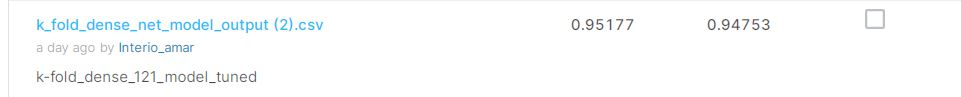

In [37]:
from IPython.display import Image 
Image(filename='k_fold_dense_net_model.JPG',width = 1000, height = 100)

#### 4.2.1 EfficientNetB7 model+K_fold

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
import h5py
from tensorflow.keras.models import load_model #for saving model weights
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_kfold = pd.DataFrame()

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
def append_ext(fn):
    return fn+".jpg"

train_df["image_id"]=train_df["image_id"].apply(append_ext)
test_df["image_id"]=test_df["image_id"].apply(append_ext)

# Creating X, Y for training 
train_y = train_df.iloc[:,1:]
train_y=tf.argmax(train_y,1)

train_x = train_df['image_id']

2022-08-27 15:35:14.864791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:35:14.995266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:35:14.999252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 15:35:15.005353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [ ]:
train_x.shape

(1821,)

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 1
N_SPLIT =5

In [ ]:
def accuracy_loss_auc_plot(History,epoch):
  #print(History)
  train_acc = History.history['accuracy']
  val_acc = History.history['val_accuracy']
  epoachs = range(1,epoch+1)
  plt.figure(figsize=(15,6))
  plt.subplot(1,3,1)
  plt.plot(epoachs,train_acc,'g',label='Training Accuracy')
  plt.plot(epoachs,val_acc,'b',label='Validation Accuracy')
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.xticks(epoachs)
  plt.ylabel("Accuracy")
  plt.legend()

  train_acc = History.history['loss']
  val_acc = History.history['val_loss']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,2)
  plt.plot(epoachs,train_acc,'g',label='Training Loss')
  plt.plot(epoachs,val_acc,'b',label='Validation Loss')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xticks(epoachs)
  plt.legend()

  train_acc = History.history['auc']
  val_acc = History.history['val_auc']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,3)
  plt.plot(epoachs,train_acc,'g',label='Training AUC')
  plt.plot(epoachs,val_acc,'b',label='Validation AUC')
  plt.title("Training and Validation AUC")
  plt.xlabel("Epochs")
  plt.ylabel("AUC")
  plt.xticks(epoachs)
  plt.legend()

  plt.tight_layout()
  plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Found 1456 validated image filenames.
Found 365 validated image filenames.


2022-08-27 15:37:33.419644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-08-27 15:37:59.818747: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 192s 2s/step - loss: 1.1462 - accuracy: 0.5652 - auc: 0.7058 - val_loss: 0.8691 - val_accuracy: 0.6591 - val_auc: 0.8517

Epoch 00001: val_loss improved from inf to 0.86907, saving model to best_model_b71.hdf5
Epoch 2/15
91/91 [==============================] - 154s 2s/step - loss: 0.7357 - accuracy: 0.7404 - auc: 0.8426 - val_loss: 0.4636 - val_accuracy: 0.8352 - val_auc: 0.9245

Epoch 00002: val_loss improved from 0.86907 to 0.46360, saving model to best_model_b71.hdf5
Epoch 3/15
91/91 [==============================] - 152s 2s/step - loss: 0.6244 - accuracy: 0.7864 - auc: 0.8868 - val_loss: 0.8868 - val_accuracy: 0.7074 - val_auc: 0.8962

Epoch 00003: val_loss did not improve from 0.46360
Epoch 4/15
91/91 [==============================] - 150s 2s/step - loss: 0.5869 - accuracy: 0.8015 - auc: 0.8856 - val_loss: 0.6960 - val_accuracy: 0.7898 - val_auc: 0.8795

Epoch 00004: val_loss did not improve from 0.46360
Epoch 5/15
91/91 [===============

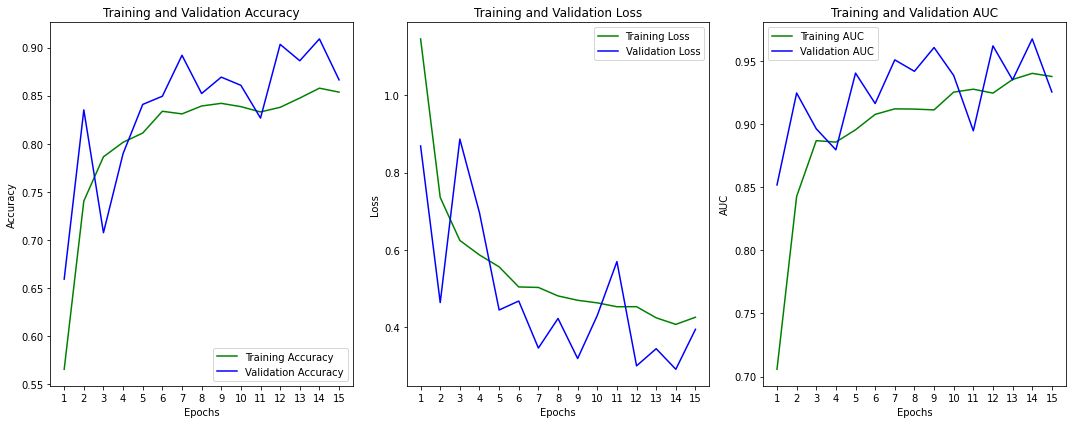

365/365 [==============================] - 22s 44ms/step


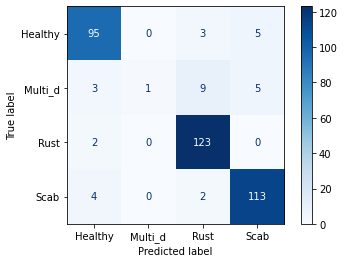

Found 1821 validated image filenames.
Concatenated data size is : (1821, 4)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 179s 2s/step - loss: 1.1108 - accuracy: 0.5836 - auc: 0.7287 - val_loss: 0.8812 - val_accuracy: 0.6761 - val_auc: 0.8897

Epoch 00001: val_loss improved from inf to 0.88119, saving model to best_model_b72.hdf5
Epoch 2/15
91/91 [==============================] - 150s 2s/step - loss: 0.7710 - accuracy: 0.7203 - auc: 0.8382 - val_loss: 0.4147 - val_accuracy: 0.8608 - val_auc: 0.9571

Epoch 00002: val_loss improved from 0.88119 to 0.41469, saving model to best_model_b72.hdf5
Epoch 3/15
91/91 [==============================] - 152s 2s/step - loss: 0.6112 - accuracy: 0.7814 - auc: 0.8848 - val_loss: 0.4044 - val_accuracy: 0.8722 - val_auc: 0.9600

Epoch 00003: val_loss improved from 0.41469 to 0.40435, saving model to best_model_b72.hdf5
Epoch 4/15
91/91 [==============================] - 150

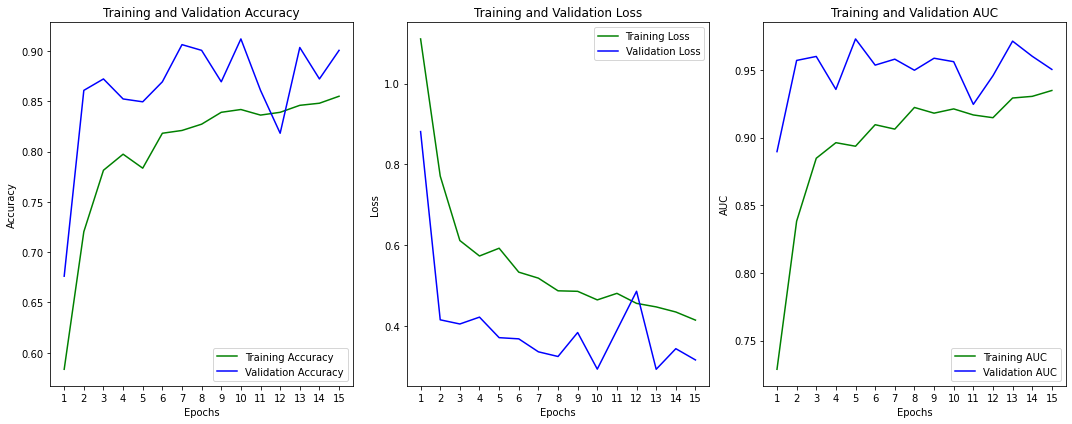

364/364 [==============================] - 23s 47ms/step


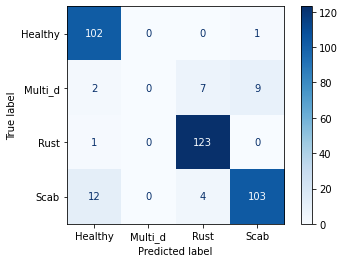

Found 1821 validated image filenames.
Concatenated data size is : (1821, 8)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 178s 2s/step - loss: 1.1350 - accuracy: 0.5517 - auc: 0.6965 - val_loss: 0.6424 - val_accuracy: 0.7699 - val_auc: 0.8944

Epoch 00001: val_loss improved from inf to 0.64245, saving model to best_model_b73.hdf5
Epoch 2/15
91/91 [==============================] - 149s 2s/step - loss: 0.7573 - accuracy: 0.7328 - auc: 0.8387 - val_loss: 0.7202 - val_accuracy: 0.7670 - val_auc: 0.8904

Epoch 00002: val_loss did not improve from 0.64245
Epoch 3/15
91/91 [==============================] - 148s 2s/step - loss: 0.6510 - accuracy: 0.7613 - auc: 0.8812 - val_loss: 0.6772 - val_accuracy: 0.7670 - val_auc: 0.8955

Epoch 00003: val_loss did not improve from 0.64245
Epoch 4/15
91/91 [==============================] - 147s 2s/step - loss: 0.5703 - accuracy: 0.7856 - auc: 0.8891 - val_loss: 0.3244 - val

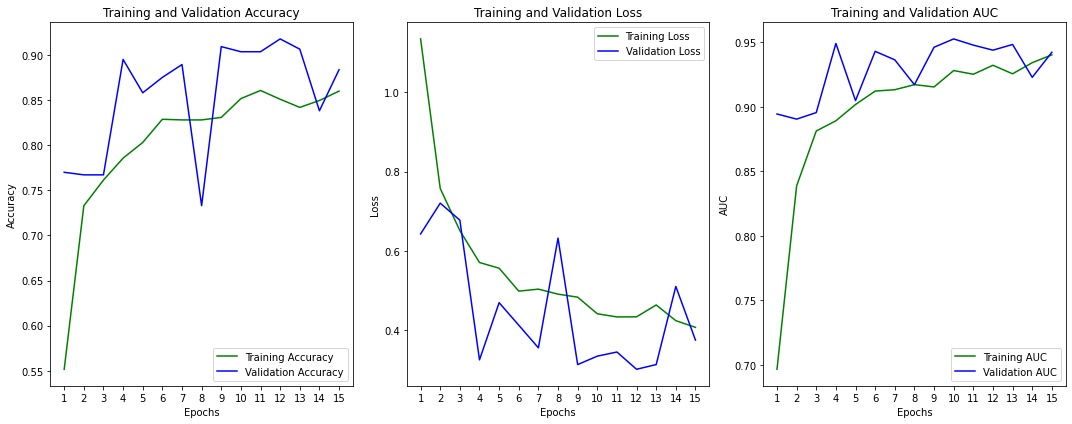

364/364 [==============================] - 24s 44ms/step


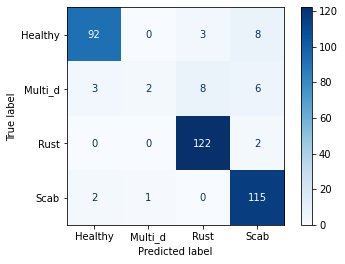

Found 1821 validated image filenames.
Concatenated data size is : (1821, 12)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 176s 2s/step - loss: 1.1799 - accuracy: 0.5455 - auc: 0.7024 - val_loss: 0.7245 - val_accuracy: 0.7102 - val_auc: 0.8811

Epoch 00001: val_loss improved from inf to 0.72452, saving model to best_model_b74.hdf5
Epoch 2/15
91/91 [==============================] - 148s 2s/step - loss: 0.7431 - accuracy: 0.7307 - auc: 0.8404 - val_loss: 0.5587 - val_accuracy: 0.8011 - val_auc: 0.9201

Epoch 00002: val_loss improved from 0.72452 to 0.55869, saving model to best_model_b74.hdf5
Epoch 3/15
91/91 [==============================] - 147s 2s/step - loss: 0.6205 - accuracy: 0.7814 - auc: 0.8705 - val_loss: 0.4364 - val_accuracy: 0.8438 - val_auc: 0.9345

Epoch 00003: val_loss improved from 0.55869 to 0.43643, saving model to best_model_b74.hdf5
Epoch 4/15
91/91 [==============================] - 14

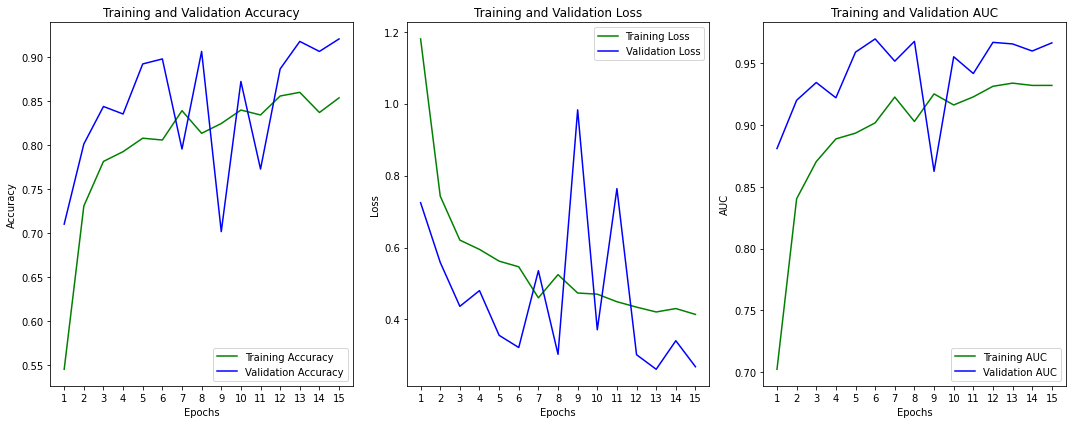

364/364 [==============================] - 22s 46ms/step


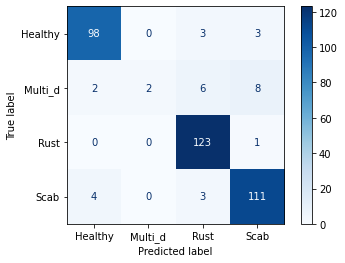

Found 1821 validated image filenames.
Concatenated data size is : (1821, 16)
Found 1457 validated image filenames.
Found 364 validated image filenames.
Epoch 1/15
91/91 [==============================] - 180s 2s/step - loss: 1.1935 - accuracy: 0.5621 - auc: 0.7011 - val_loss: 0.6382 - val_accuracy: 0.7727 - val_auc: 0.8933

Epoch 00001: val_loss improved from inf to 0.63824, saving model to best_model_b75.hdf5
Epoch 2/15
91/91 [==============================] - 153s 2s/step - loss: 0.7721 - accuracy: 0.7169 - auc: 0.8353 - val_loss: 0.5553 - val_accuracy: 0.8040 - val_auc: 0.8988

Epoch 00002: val_loss improved from 0.63824 to 0.55526, saving model to best_model_b75.hdf5
Epoch 3/15
91/91 [==============================] - 149s 2s/step - loss: 0.6571 - accuracy: 0.7703 - auc: 0.8700 - val_loss: 0.4949 - val_accuracy: 0.8239 - val_auc: 0.8990

Epoch 00003: val_loss improved from 0.55526 to 0.49488, saving model to best_model_b75.hdf5
Epoch 4/15
91/91 [==============================] - 15

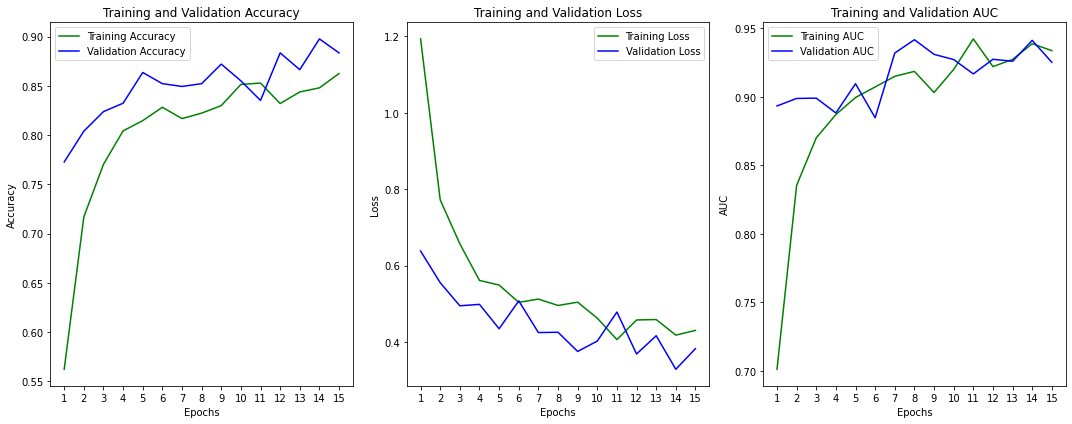

364/364 [==============================] - 22s 45ms/step


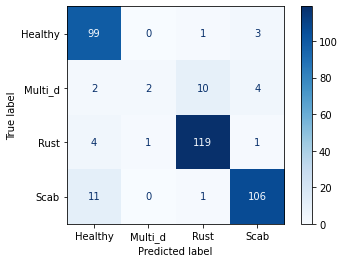

Found 1821 validated image filenames.
Concatenated data size is : (1821, 20)


In [ ]:
#https://github.com/r-sajal/DeepLearning-/blob/master/ComputerVision/k-fold-accuracy-comparison-blog.ipynb -->>K Fold cv
#https://www.kaggle.com/code/skeef79/plant-pathology-2020-efficientnetb7-0-980-score
from keras.applications.densenet import DenseNet201, DenseNet121
from tqdm.notebook import tqdm
import pandas as pd
import tensorflow as tf
import gc
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

# Storing the average of all predictions
data_kfold = pd.DataFrame()

#Initializing Data Generators
train_datagen=ImageDataGenerator(rescale=1./255.,
                                 rotation_range=45, 
                                shear_range=.25,
                                zoom_range = 0.20, 
                                width_shift_range= 0.25,
                                height_shift_range= 0.25, 
                                brightness_range=[.5,1.5],
                                horizontal_flip=True, 
                                vertical_flip=True,
                                fill_mode = 'nearest'
                                 )
validation_datagen=ImageDataGenerator(rescale=1./255.)

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

j = 0

# K-fold Train and test for each split
for train_idx, val_idx in tqdm(list(kfold.split(train_x,train_y))):
    x_train_df = train_df.iloc[train_idx]
    x_valid_df = train_df.iloc[val_idx]
    j+=1
    
  
    training_set=train_datagen.flow_from_dataframe(
                            dataframe=x_train_df,
                            directory="./images/",
                            x_col="image_id",
                            y_col=x_train_df.columns[1:].str.replace(' ', ''),
                            # subset=None,
                            batch_size=16,
                            seed=42,
                            shuffle=True,
                            class_mode="raw",
                            target_size=(320,512))


    validation_set=validation_datagen.flow_from_dataframe(
                            dataframe=x_valid_df,
                            directory="./images/",
                            x_col="image_id",
                            y_col=x_valid_df.columns[1:].str.replace(' ', ''),
                            # subset=None,
                            batch_size=16,
                            seed=42,
                            shuffle=False,
                            class_mode="raw", #https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
                            target_size=(320,512))
    
        

    METRICS = [ 
              tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
              tf.keras.metrics.AUC(name='auc',multi_label=True),
                ]


    base_model = efn.EfficientNetB7(weights = 'imagenet', include_top=False, input_shape = (320,512,3))
    base_model.trainable = True
    for layer in base_model.layers[:-3] : #exclusing the last conv block 
        layer.trainable = False # freezing all the layers
      
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(512,activation='relu',kernel_initializer='he_normal')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x=Dropout(0.3)(x)
    x=Dense(256,activation='relu',kernel_initializer='he_normal')(x) #dense layer 2
    preds=Dense(4,activation='softmax')(x) #final layer with softmax activation
    model_b7_1=Model(inputs=base_model.input,outputs=preds)

    
    filepath="best_model_b7{}.hdf5".format(j)
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True,  verbose=1, mode='min')   
    #earlystop = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=8, verbose=1)

    callback=[checkpoint]  #,earlystop

    model_b7_1.compile(optimizer='adam',
                        loss = 'categorical_crossentropy',
                        metrics=METRICS)
            
       
    STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
    STEP_SIZE_VALID=validation_set.n//validation_set.batch_size

    epoch =15
    history = model_b7_1.fit_generator(training_set,
            steps_per_epoch = STEP_SIZE_TRAIN, #train_size//batch_size
            epochs=epoch,               
            verbose=1,
            validation_data=validation_set,
            validation_steps=STEP_SIZE_VALID,callbacks=callback     
           )
    #print(history.history)
    accuracy_loss_auc_plot(history,epoch)
    #saving only the best model
    loaded_model = tf.keras.models.load_model('best_model_b7{}.hdf5'.format(j))
    #vaidation data prediction agin for confusion matrix 

    validation_set.reset()
    pred_1=loaded_model.predict_generator(validation_set,steps=validation_set.n,verbose=1)

    #plotting function of accuracy,loss and auc
    
    #confusion_matrix on each fold
    class_labels = ["Healthy", "Multi_d", "Rust", "Scab"]
    cm = confusion_matrix(np.asarray(validation_set._targets).argmax(axis=1), np.asarray(pred_1).argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    test_datagen=ImageDataGenerator(rescale=1./255.)

    test_generator=test_datagen.flow_from_dataframe(
                dataframe=test_df,
                directory="./images/",
                x_col="image_id",
                y_col=None,
                batch_size=1,
                seed=42,
                shuffle=False,
                class_mode=None,
                target_size=(320,512))
                    
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    test_generator.reset()
    pred= loaded_model.predict(test_generator, STEP_SIZE_TEST)

    pred1=pd.DataFrame(pred,columns=["healthy"+'{}'.format(j), "multiple_diseases"+'{}'.format(j), "rust"+'{}'.format(j),"scab"+'{}'.format(j)])

    pred1.reset_index(drop=True, inplace=True)
    # print(pred1.shape)
    # print(data_kfold.shape)                      
    data_kfold=pd.concat([data_kfold,pred1],axis=1)

    print("Concatenated data size is :",data_kfold.shape)
    tf.keras.backend.clear_session()
    gc.collect()

#### Observations:

* 5 fold startified K-fold cross validation method is used.
* Image is resized to 320X512 for input,validation and test dataset
* Achieved on average of 0.9565 ROC AUC score on all 5 folds
* Achieved average accuracy of 0.90 in all 5 folds.


In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

data_kfold.to_csv('k_fold_eff_b7.csv')

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='k_fold_eff_b7.csv')

In [ ]:
data_kfold[:2]

,healthy1,multiple_diseases1,rust1,scab1,healthy2,multiple_diseases2,rust2,scab2,healthy3,multiple_diseases3,rust3,scab3,healthy4,multiple_diseases4,rust4,scab4,healthy5,multiple_diseases5,rust5,scab5
0,0.000004,0.005398,0.994584,0.000014,3.561281e-07,0.000256,0.999742,0.000002,0.000004,0.007433,0.992470,0.000092,0.000003,0.000500,0.999492,0.000005,4.337298e-07,0.000483,0.999516,8.210409e-07
1,0.000848,0.010387,0.987529,0.001236,1.608503e-05,0.003013,0.996834,0.000137,0.000032,0.097993,0.898491,0.003485,0.000006,0.007098,0.992831,0.000065,7.935849e-05,0.014901,0.984589,4.304544e-04


In [ ]:
data_kfold.iloc[:,0::4][:3]

,healthy1,healthy2,healthy3,healthy4,healthy5
0,0.000004,3.561281e-07,0.000004,0.000003,4.337298e-07
1,0.000848,1.608503e-05,0.000032,0.000006,7.935849e-05
2,0.012984,2.944936e-02,0.000198,0.002309,4.696280e-03


In [ ]:
final_df=pd.DataFrame()

for i,j in enumerate(['healthy','multiple_diseases', 'rust', 'scab']):
  test_avg_column=pd.DataFrame(data_kfold.iloc[:,i::4].sum(axis=1)/N_SPLIT,columns=[j])
  final_df =pd.concat([final_df,test_avg_column],axis=1)

In [ ]:
submission =final_df

In [ ]:
test_df2=test_df['image_id'].map(lambda x: x.split('.')[0])
submission.insert(0,'image_id',test_df2)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

submission.to_csv('k_fold_eff_b7_model_output.csv',index=False)

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='k_fold_eff_b7_model_output.csv')

Kaggle Score acheived was: 0.93513 roc_auc as Public score and 0.92826 roc_auc as Prive score

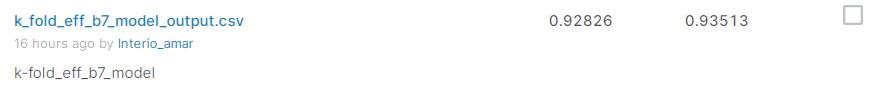

In [39]:
from IPython.display import Image 
Image(filename='k_fold_eff_b7_score.JPG',width = 1000, height = 100)

### EfficientNet B7+ Smote

In [ ]:
#Converting Image into an array
#https://www.kaggle.com/code/nikitaryabukhin/pathology-notebook  -->> reference for smote 
import cv2
import tensorflow as tf
from tqdm.notebook import tqdm
train_df = pd.read_csv("train.csv")
def append_ext(fn):
    return 'images/'+fn+".jpg"
train_df["image_id"]=train_df["image_id"].apply(append_ext)

training_images = []
for index, image in tqdm(enumerate(train_df['image_id'])):
    image = cv2.imread(image)
    image = cv2.resize(image, (300, 300), interpolation=cv2.INTER_AREA) #dim = (width, height) in resize [1,0] shape in image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    training_images.append(image)

0it [00:00, ?it/s]

In [ ]:
#matrix of (shape 1821 * IMAGE_WIDTH * IMAGE_HEIGHT) creation here 1821 is the array converted trai images. Since SMOTE requires an array as input
x_train_full = np.ndarray(shape=(len(training_images), 300, 300,3),dtype=np.float32)

In [ ]:
for index, image in tqdm(enumerate(training_images)): 
    x_train_full[index] = training_images[index] 
x_train_full = x_train_full/255
print(x_train_full.shape)

0it [00:00, ?it/s]

(1821, 300, 300, 3)


In [ ]:
y_train_full=train_df.iloc[:,1:]
print("Target clas shape is :",y_train_full.shape)

Target clas shape is : (1821, 4)


In [ ]:
from sklearn.model_selection import train_test_split
import efficientnet.tfkeras as efn
X_train, X_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.2, random_state = 42,stratify=y_train_full)

In [ ]:
print("Train data shape now is      : ",X_train.shape,y_train.shape)
print("Validation data shape now is : ",X_val.shape,y_val.shape)

Train data shape now is      :  (1456, 300, 300, 3) (1456, 4)
Validation data shape now is :  (365, 300, 300, 3) (365, 4)


In [ ]:
y_train=tf.argmax(y_train,1)
# y_val=tf.argmax(y_val,1)
# print(y_train.shape,y_val.shape)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', k_neighbors=5)

x_train, y_train = oversample.fit_resample(X_train.reshape((-1, 300 * 300 *3)), y_train)
x_train = x_train.reshape((-1, 300, 300, 3))

In [ ]:
print(x_train.shape,y_train.shape)

(1880, 300, 300, 3) (1880,)


In [ ]:
y_train_1=pd.DataFrame(tf.keras.utils.to_categorical(y_train),columns=list(y_train_full.columns),dtype='int64')

In [ ]:
#Initializing Data Generators
#https://github.com/tensorflow/tensorflow/issues/43938  -->> scale the image once only rescaling to 255 results o bad performance
from keras_preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                           
                                 )
validation_datagen=ImageDataGenerator()

In [ ]:
from tensorflow.keras.layers import BatchNormalization
base_model = efn.EfficientNetB7(weights = 'imagenet', include_top=False, input_shape = (300,300,3))
base_model.trainable = True
for layer in base_model.layers[:-3] : #exclusing the last conv block 
    layer.trainable = False # freezing all the layers
x=base_model.output
#x=BatchNormalization()(x)
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu',kernel_initializer='he_normal')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dropout(0.3)(x)
x=Dense(256,activation='relu',kernel_initializer='he_normal')(x) #dense layer 2
preds=Dense(4,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)

METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc',multi_label=True),
        ]
    
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics =METRICS)       

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten,MaxPool2D,Input
from pathlib import Path
import numpy as np

auc = tf.keras.metrics.AUC()
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1)


filepath="best_mdel_smote.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='min') 

callback_list=[earlystop,checkpoint]

In [ ]:
BATCH_SIZE =16
history_b7 = model.fit(train_datagen.flow(x_train, y_train_1, batch_size = BATCH_SIZE),
                    epochs = 30, 
                    steps_per_epoch = x_train.shape[0]//BATCH_SIZE,
                    validation_data =validation_datagen.flow(X_val,y_val, batch_size = BATCH_SIZE),
                    validation_steps = X_val.shape[0] // BATCH_SIZE,
                    callbacks= callback_list, 
                    verbose = 1
                   )

Epoch 1/30
117/117 [==============================] - 72s 462ms/step - loss: 1.1138 - accuracy: 0.5451 - auc: 0.7918 - val_loss: 0.8619 - val_accuracy: 0.7102 - val_auc: 0.8685

Epoch 00001: val_loss improved from inf to 0.86190, saving model to best_mdel_smote.hdf5
Epoch 2/30
117/117 [==============================] - 50s 425ms/step - loss: 0.8075 - accuracy: 0.6964 - auc: 0.8896 - val_loss: 0.6375 - val_accuracy: 0.7614 - val_auc: 0.8903

Epoch 00002: val_loss improved from 0.86190 to 0.63754, saving model to best_mdel_smote.hdf5
Epoch 3/30
117/117 [==============================] - 49s 419ms/step - loss: 0.7088 - accuracy: 0.7285 - auc: 0.9139 - val_loss: 0.4679 - val_accuracy: 0.8068 - val_auc: 0.9379

Epoch 00003: val_loss improved from 0.63754 to 0.46795, saving model to best_mdel_smote.hdf5
Epoch 4/30
117/117 [==============================] - 50s 423ms/step - loss: 0.6396 - accuracy: 0.7543 - auc: 0.9296 - val_loss: 0.5241 - val_accuracy: 0.8295 - val_auc: 0.9337

Epoch 00004: 

#### Observations:
* Used Image Size of 300X 300 to keep the RAM running efficient
* SMOTE is applied on minority class
* Achieved Validation ROC AUC score of 0.9600 and validation accuracy of 0.8864

In [ ]:
def accuracy_loss_auc_plot(History,epoch):
  #print(History)
  train_acc = History.history['accuracy']
  val_acc = History.history['val_accuracy']
  epoachs = range(1,epoch+1)
  plt.figure(figsize=(15,6))
  plt.subplot(1,3,1)
  plt.plot(epoachs,train_acc,'g',label='Training Accuracy')
  plt.plot(epoachs,val_acc,'b',label='Validation Accuracy')
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epochs")
  plt.xticks(epoachs)
  plt.ylabel("Accuracy")
  plt.legend()

  train_acc = History.history['loss']
  val_acc = History.history['val_loss']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,2)
  plt.plot(epoachs,train_acc,'g',label='Training Loss')
  plt.plot(epoachs,val_acc,'b',label='Validation Loss')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xticks(epoachs)
  plt.legend()

  train_acc = History.history['auc']
  val_acc = History.history['val_auc']
  epoachs = range(1,epoch+1)
  plt.subplot(1,3,3)
  plt.plot(epoachs,train_acc,'g',label='Training AUC')
  plt.plot(epoachs,val_acc,'b',label='Validation AUC')
  plt.title("Training and Validation AUC")
  plt.xlabel("Epochs")
  plt.ylabel("AUC")
  plt.xticks(epoachs)
  plt.legend()

  plt.tight_layout()
  plt.show()

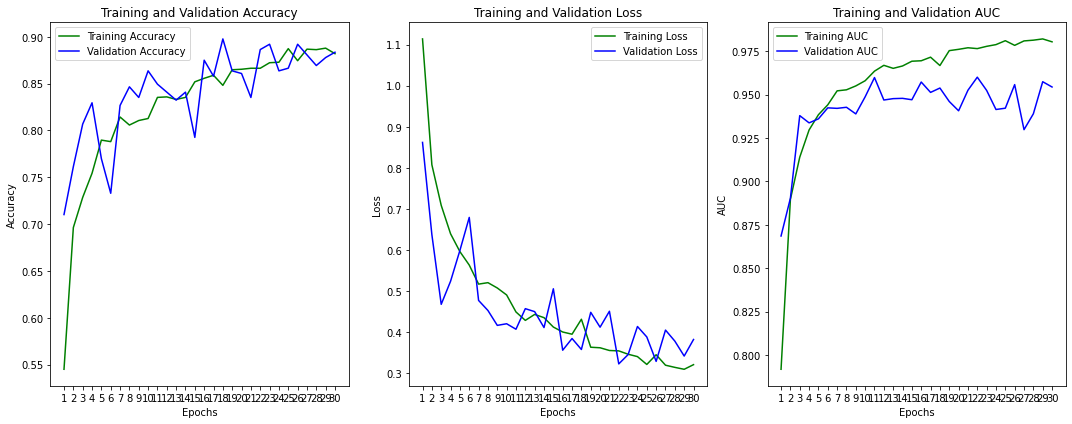

In [ ]:
accuracy_loss_auc_plot(history_b7,30)

In [ ]:
import h5py
import tensorflow as tf
from tensorflow.keras.models import load_model
loaded_model = tf.keras.models.load_model('best_model_dense.hdf5')

2022-08-28 10:43:02.309476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:43:02.415600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:43:02.416426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:43:02.417765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

365/365 [==============================] - 8s 22ms/step


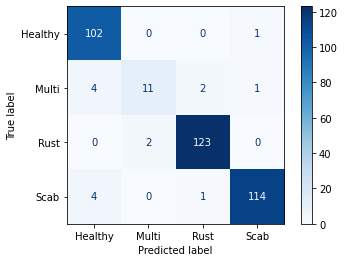

In [ ]:
#vaidation data prediction agin for confusion matrix 

#valid_generator.reset()
pred_1=loaded_model.predict_generator(validation_datagen.flow(X_val,y_val, batch_size = 1,shuffle=False),steps=X_val.shape[0],verbose=1)

#plotting function of accuracy,loss and auc
    
#confusion_matrix on each fold
class_labels = ["Healthy", "Multi", "Rust", "Scab"]
cm = confusion_matrix(np.asarray(y_val).argmax(axis=1), np.asarray(pred_1).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
#achieved accuracy of 96% on validation data

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_df=pd.read_csv('test.csv')
def append_ext(fn):
    return fn+".jpg"
test_df["image_id"]=test_df["image_id"].apply(append_ext)


In [ ]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="./images/",
x_col="image_id",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(320,512))

Found 1821 validated image filenames.


In [ ]:
#valid_generator.reset()
pred_test=loaded_model.predict_generator(test_generator,steps=test_generator.n,verbose=1)

1821/1821 [==============================] - 88s 47ms/step


In [ ]:
submission_b7_smote = pd.DataFrame(pred_test, columns = ["healthy", "multiple_diseases", "rust","scab"],)

In [ ]:
test_df1=test_df['image_id'].map(lambda x: x.split('.')[0])

In [ ]:
submission_b7_smote.insert(0,'image_id',test_df1)

In [ ]:
submission_b7_smote.to_csv('EfficientNetB7_smote.csv',index=False)

In [ ]:
from IPython.display import HTML
import pandas as pd
import numpy as np

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='EfficientNetB7_smote.csv')

Achieved Public score: 0.93788 and Private Score: 0.92908 in Kaggle submission

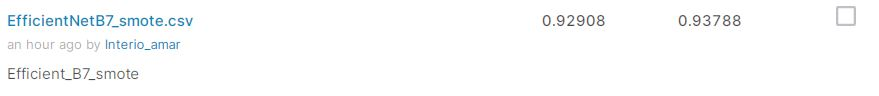

In [41]:
from IPython.display import Image 
Image(filename='eff_b7_smote.JPG',width = 1000, height = 100)